# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Xiaotong

Last Name: Wang

Student ID: 913738935

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [60]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapefile as shp
import matplotlib
import geopandas as gp
import shapely.geometry as geom
#from mpl_toolkits.basemap import Basemap

conn3 = sqlite3.connect("sf_data.sqlite")
#c = conn3.cursor()
mobile_food_locations = pd.read_sql_query('select * from mobile_food_locations', conn3)
#select the Longtitude data from mobile_food_locations
mobile_food_locations.head()


#c.execute("""select *, count(*) from mobile_food_locations""")
#c.execute("""select *, count(*) from mobile_food_permits""")

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105


In [2]:
# conn3 = sqlite3.connect("sf_data.sqlite")
# c = conn3.cursor()
# c.execute("""select * from mobile_food_locations""")
# c.fetchone()

In [3]:
mobile_food_permits = pd.read_sql_query('select * from mobile_food_permits', conn3)
#select the data from mobile_food_permits
mobile_food_permits.head()


,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None


In [4]:
mobile_food_schedule = pd.read_sql_query('select * from mobile_food_schedule', conn3)
#select the data from mobile_food_permits
mobile_food_schedule.head()

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [5]:
sql_query = """ 
SELECT Applicant, mobile_food_permits.permit, count(DISTINCT locationid) as loc_count from mobile_food_permits
INNER JOIN mobile_food_schedule
ON mobile_food_permits.permit = mobile_food_schedule.permit
GROUP BY Applicant
order by loc_count desc
"""
food_sells = pd.read_sql_query(sql_query,conn3)
food_sells.head()

,Applicant,permit,loc_count
0,May Catering,17MFF-0110,58
1,Anas Goodies Catering,17MFF-0111,37
2,Natan's Catering,13MFF-0102,37
3,Liang Bai Ping,17MFF-0090,33
4,Park's Catering,16MFF-0051,23


In [6]:
Approved_sql_query = """ 
SELECT Applicant, mobile_food_permits.permit, Status, count(DISTINCT locationid) as loc_count from mobile_food_permits
INNER JOIN mobile_food_schedule
ON mobile_food_permits.permit = mobile_food_schedule.permit
WHERE Status = 'APPROVED'
GROUP BY Applicant
order by loc_count desc
"""
Approved_food_sells = pd.read_sql_query(Approved_sql_query,conn3)
Approved_food_sells.head()

,Applicant,permit,Status,loc_count
0,Park's Catering,16MFF-0051,APPROVED,23
1,D & T Catering,16MFF-0037,APPROVED,17
2,F & C Catering,16MFF-0027,APPROVED,13
3,Munch A Bunch,16MFF-0069,APPROVED,10
4,Eva's Catering,16MFF-0055,APPROVED,8


From above, I connected the mobile_food_permits and mobile_food_schedule, based all the data, the mobile food vendor(s) sells at the most locations is May Catering, the count is 58. And then I selected the data by status which is APPROVED the mobile food vendor(s) sells at the most locations is Park's Catering, the count is 23

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

Question1: Which parts of the city are the most and least expensive?

    RegionName     avg_sold   avg_rent
0        94123   696.166788  26.086711
1        94114   650.127729  23.930658
2        94127   490.745386  23.869211
3        94121   467.890585  22.997500
4        94131   560.122866  22.725921
5        94117   580.217632  21.962368
6        94115   611.771452  21.522500
7        94122   453.210167  21.468684
8        94116   466.570200  21.361711
9        94133   638.636839  21.344474
10       94110   543.998864  21.088947
11       94105   798.257824  20.133816
12       94132   385.384982  19.757368
13       94111   445.680441  19.746184
14       94158   657.211820  19.415789
15       94109   618.325709  19.251316
16       94107   592.651062  19.067105
17       94108   501.013201  18.649474
18       94080   375.629802  18.342105
19       94112   416.744886  17.992895
20       94103   604.009929  17.654868
21       94134   347.027455  17.030000
22       94102   626.417276  16.411053
23       94124   297.008046  15.119605
24       94104  1336.1285

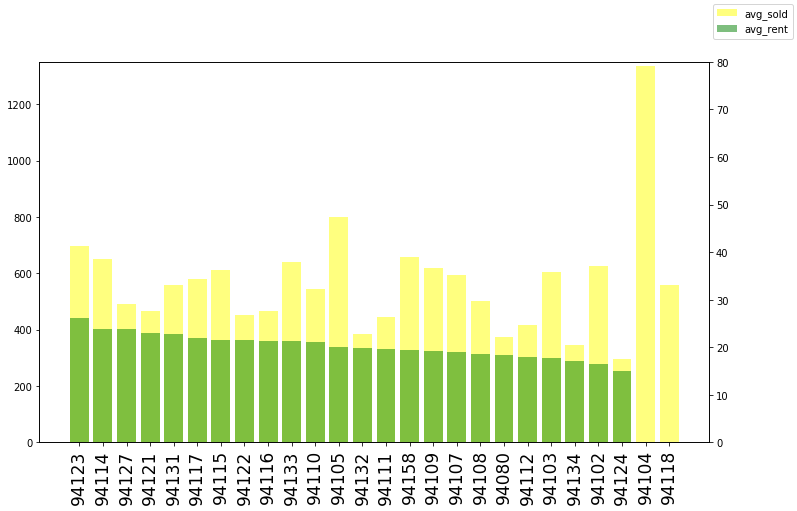

In [7]:
zillow = pd.read_sql_query('select * from zillow', conn3)

zillow_sql_query = """
SELECT RegionName, AVG(MedianSoldPricePerSqft_AllHomes) as avg_sold, AVG(PriceToRentRatio_AllHomes) as avg_rent from zillow 

GROUP BY RegionName
ORDER BY avg_rent desc
"""
zillow_data = pd.read_sql_query(zillow_sql_query,conn3)
print(zillow_data)

fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()

x = range(len(zillow_data['RegionName']))
ax.set_xticks(x)
ax.set_xticklabels(zillow_data['RegionName'], rotation = 'vertical', size = 17)
ax.set_ylim(0,1350)
ax2.set_ylim(0,80)
ax.bar(x, zillow_data['avg_sold'],color = 'yellow', alpha = 0.5, label = 'avg_sold')
ax2.bar(x, zillow_data['avg_rent'], color = 'green', alpha = 0.5, label = 'avg_rent')
fig.legend()
plt.show()


For this question, I used the data of Zillow to identify which parts of the city are the most and least expensive. It has several variables and then I chose the 'RegionName','MedianSoldPricePerSqft_AllHomes', and 'PriceToRentRatio_AllHomes' and calculated the average of the sold price and rent ratio by name, and then set the order by average of rent ratios, which is the table shows above. Next, I plotted one graph by using two data from table as above. X is the region name, and yellow bar is average of sold price, and the green bar is average of rent ratio. We can see from plot, the area of the highest sold price is "94104" where is the near Embarcadero and Financial district and the least expensive is '94124' where is Bayview-Hunters Point. Therefore, I think that because of Embarcadero the worth of home is high, but it is not good for rent, so there is no rent ratio of that area. The most expensive area of rent is Marina District, also has the higher price of sold.

Qustion2: Which parts of the city are the most dangerous and at what times?

   DayOfWeek PdDistrict  crime_count
0     Friday   SOUTHERN        24869
1   Saturday   SOUTHERN        23963
2  Wednesday   SOUTHERN        22209
3   Thursday   SOUTHERN        22003
4    Tuesday   SOUTHERN        20946


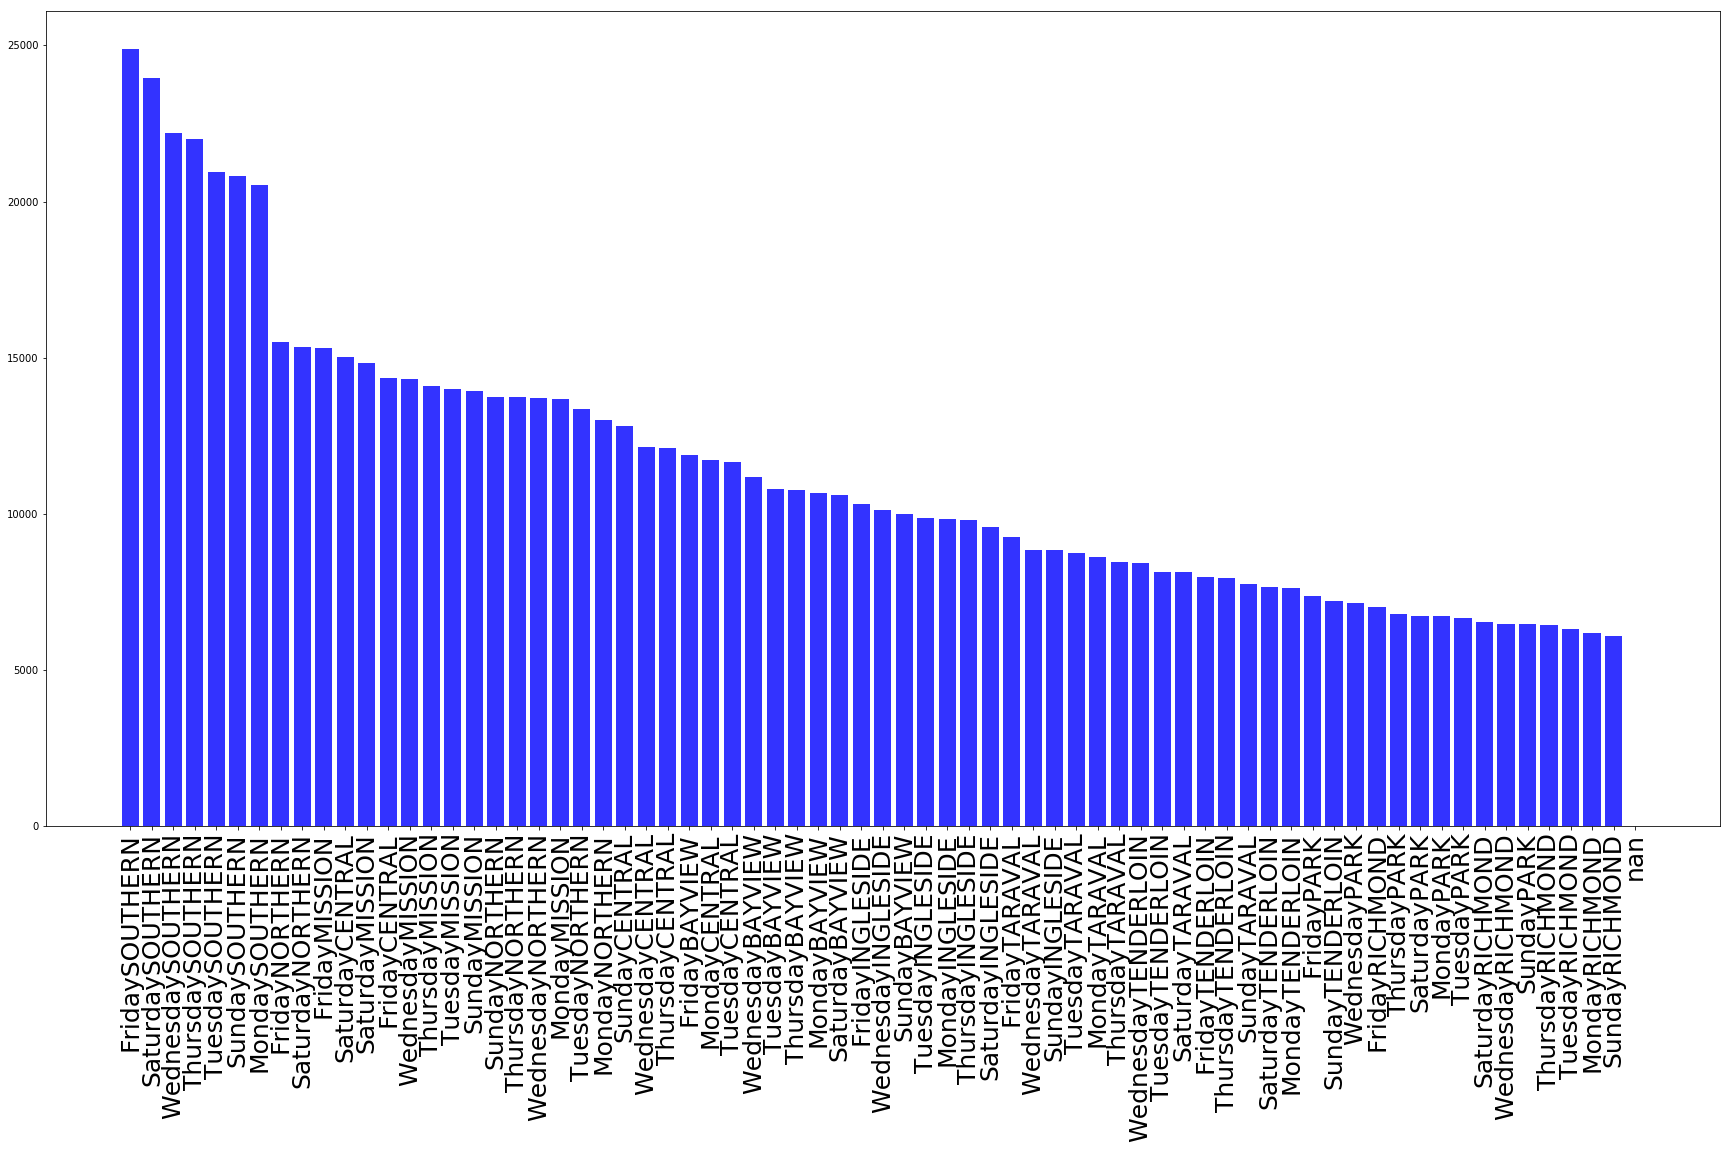

In [8]:
crime = pd.read_sql_query('select * from crime', conn3)

crime_sql_query = """
SELECT DayOfWeek, PdDistrict, count(DISTINCT IncidntNum) as crime_count from crime
GROUP BY DayOfWeek, PdDistrict
ORDER BY crime_count desc
"""
crime_data = pd.read_sql_query(crime_sql_query,conn3)
print(crime_data.head())

fig, ax = plt.subplots(figsize=(30, 15))

x = range(len(crime_data))
ax.set_xticks(x)
labels = crime_data['DayOfWeek'] + crime_data['PdDistrict']
plt.xticks(x, labels, rotation = 'vertical', size = 25)
ax.bar(x, crime_data['crime_count'], color = "blue", alpha = 0.8)
plt.show()

In [9]:
crime_sql_query1 = """
SELECT DayOfWeek, PdDistrict, Descript, count(DISTINCT Descript) as descript_count from crime
WHERE DayOfWeek = 'Friday' and PdDistrict = 'SOUTHERN'
GROUP BY PdDistrict
ORDER BY descript_count desc
"""
crime_data1 = pd.read_sql_query(crime_sql_query1,conn3)
print(crime_data1)

  DayOfWeek PdDistrict                      Descript  descript_count
0    Friday   SOUTHERN  CREDIT CARD, THEFT BY USE OF             544


For this question, I used the data of crime to identify Which parts of the city are the most dangerous and at what time. It has several variables and then I chose the "DayOfWeek", "PdDistrict", and "IncidntNum", and count the number of crime by each day of week and district and then make a plot. From the table and plot, we can see the most dangerous area is Southern district and the day of the week is Friday, the count is 24869. I found that there is an error data which is one time on Sunday but no district. Moreover, I made a small range data which is Southern district on Friday to figure out the descript of crime which is theft by use of credit card, the number of that crime is 544.

Question3: Are noise complaints and mobile food vendors related?

In [31]:
noise = pd.read_sql_query('select * from noise', conn3)

noise_sql_query = """
SELECT Type, count(Type) as type_count from noise
GROUP BY Type
ORDER BY type_count
"""
noise_data = pd.read_sql_query(noise_sql_query,conn3)
print(noise_data.head())


                            Type  type_count
0                       hospital           4
1           mobile_food_facility           7
2  delivery_service_construction           9
3            emergency_equipment           9
4                  public_speech           9


In [73]:
noise = pd.read_sql_query('select * from noise', conn3)

noise_sql_query = """
SELECT Type, Neighborhood, Lat, Lon from noise
WHERE Type = 'mobile_food_facility'
"""
noise_data = pd.read_sql_query(noise_sql_query,conn3)
noise_data

,Type,Neighborhood,Lat,Lon
0,mobile_food_facility,Mission,37.768141,-122.419785
1,mobile_food_facility,Castro,37.761364,-122.434097
2,mobile_food_facility,South of Market,37.780362,-122.409218
3,mobile_food_facility,Mission,37.768141,-122.419785
4,mobile_food_facility,Panhandle,37.773512,-122.450718
5,mobile_food_facility,Mission,37.769046,-122.413270
6,mobile_food_facility,Mission,37.768402,-122.419721


In [72]:
truck_sql_query = """
SELECT mobile_food_locations.locationid, mobile_food_permits.permit, mobile_food_permits.FacilityType, Latitude, Longitude from mobile_food_locations
INNER JOIN mobile_food_schedule ON mobile_food_schedule.locationid = mobile_food_locations.locationid
INNER JOIN mobile_food_permits ON mobile_food_permits.permit = mobile_food_schedule.permit
WHERE FacilityType = 'Truck'
AND Status = 'APPROVED'
AND Latitude != 0
AND Longitude != 0
GROUP BY mobile_food_locations.locationid 
ORDER BY Longitude DESC
"""

truck_data = pd.read_sql_query(truck_sql_query,conn3)
truck_data.head()

,locationid,permit,FacilityType,Latitude,Longitude
0,765689,16MFF-0051,Truck,37.730906,-122.373303
1,765709,16MFF-0051,Truck,37.732135,-122.375398
2,762187,16MFF-0027,Truck,37.737727,-122.376573
3,765707,16MFF-0051,Truck,37.737727,-122.376573
4,765708,16MFF-0051,Truck,37.726383,-122.378435


For this question, I used the data of noise and data about mobile food vendor to identify the relationship of noise complaints and mobile food vendors. First, I select the Type of noise and count that, so I got several Type and I think only the 'mobile_food_facility' is related to the mobile food vendor and only has 7 complaints; therefore, I might be hypothesize that there is no strong relationship between noise complain and mobile food vendors. Second, I picked up this 7 complaints to show the latitude and longitude. Third, I selected the data of latitude and longitude about food truck which status is approved.

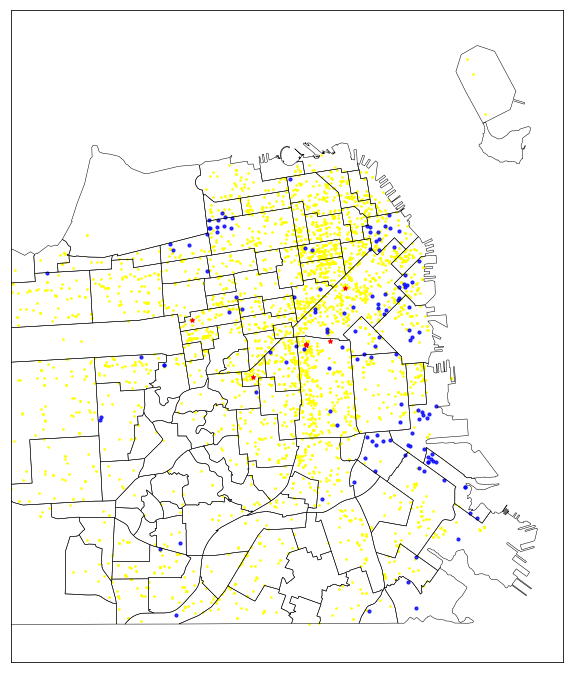

In [74]:
from mpl_toolkits.basemap import Basemap
#import matplotlib.cm as cm

cmap = plt.cm.seismic
matplotlib.rcParams['figure.figsize'] = (12,12)
cmap = Basemap(llcrnrlat=37.7, urcrnrlat=37.84, llcrnrlon=-122.5, urcrnrlon=-122.35, resolution='i',projection='merc')

cmap.readshapefile('geo_export_d425fcfa-8090-48e6-bc5e-fb751ae92321', 'sfneighborhoods')

x1,y1 = cmap(list(noise.Lon),list(noise.Lat))
x2,y2 = cmap(list(truck_data.Longitude),list(truck_data.Latitude))
x3,y3 = cmap(list(noise_data.Lon),list(noise_data.Lat))

cmap.scatter(x1,y1,s=10,c='yellow',marker=".",alpha=1, label = "Noise")
cmap.scatter(x2,y2,s=10,c='blue',marker="o",alpha=0.8, label = "Food Truck")
cmap.scatter(x3,y3,s=20,c='red', marker='*')



From the plot above, all the data of the noise complaints are scattered around the city which are labeled in yellow point, and the food trucks are located at north-east of San Francisco which are labeled in blue point, and labeled the 7 complaints of mobile_food_facility in red star. We can see that most of noise complaints are not near the location of food truck obviously, so that is support my hypthesis there is no strong relationship between food truck locations and noise complaints.

Question4:What are the best times and places to find food trucks?

In [28]:
findtruck_sql_query = """
SELECT Address, DayOfWeek, StartHour, EndHour, FacilityType, Latitude, Longitude from mobile_food_locations
INNER JOIN mobile_food_schedule ON mobile_food_schedule.locationid = mobile_food_locations.locationid
INNER JOIN mobile_food_permits ON mobile_food_permits.permit = mobile_food_schedule.permit
WHERE FacilityType = 'Truck'
AND Status = 'APPROVED'
AND Latitude != 0
AND Longitude != 0
ORDER BY DayOfWeek
"""

findtruck_data = pd.read_sql_query(findtruck_sql_query,conn3)
findtruck_data.head()


,Address,DayOfWeek,StartHour,EndHour,FacilityType,Latitude,Longitude
0,2890 03RD ST,Fr,6,9,Truck,37.753109,-122.388170
1,2890 03RD ST,Fr,0,13,Truck,37.753109,-122.388170
2,1275 MINNESOTA ST,Fr,9,10,Truck,37.754252,-122.389381
3,900 07TH ST,Fr,9,10,Truck,37.769829,-122.400101
4,355 BRANNAN ST,Fr,9,10,Truck,37.780561,-122.392849


In [56]:
parks = pd.read_sql_query('select * from parks', conn3)

parks_sql_query = """
SELECT parks.Name, parks.Lat, parks.Lon from parks
WHERE parks.Lat != 0
AND parks.Lon != 0
"""
parks_data = pd.read_sql_query(parks_sql_query,conn3)
parks_data.head()

,Name,Lat,Lon
0,10TH AVE/CLEMENT MINI PARK,37.781844,-122.468099
1,15TH AVENUE STEPS,37.759565,-122.472268
2,24TH/YORK MINI PARK,37.753060,-122.408575
3,29TH/DIAMOND OPEN SPACE,37.743602,-122.435236
4,ADAM ROGERS PARK,37.731016,-122.383855


In [52]:
schools = pd.read_sql_query('select * from schools', conn3)

schools_sql_query = """
SELECT schools.Name, parks.Name, schools.Lat, schools.Lon from schools
INNER JOIN parks
WHERE schools.Lat != 0
AND schools.Lon != 0
"""

schools_data = pd.read_sql_query(schools_sql_query,conn3)
schools_data.head()

,Name,Name,Lat,Lon
0,Alamo Elementary School,10TH AVE/CLEMENT MINI PARK,37.783005,-122.4823
1,Alamo Elementary School,15TH AVENUE STEPS,37.783005,-122.4823
2,Alamo Elementary School,24TH/YORK MINI PARK,37.783005,-122.4823
3,Alamo Elementary School,29TH/DIAMOND OPEN SPACE,37.783005,-122.4823
4,Alamo Elementary School,ADAM ROGERS PARK,37.783005,-122.4823


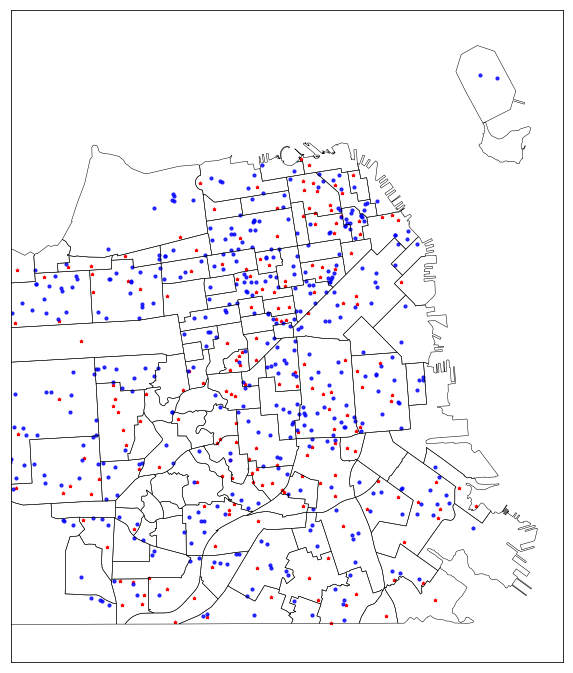

In [68]:

from mpl_toolkits.basemap import Basemap
#import matplotlib.cm as cm

cmap = plt.cm.seismic
matplotlib.rcParams['figure.figsize'] = (12,12)
cmap = Basemap(llcrnrlat=37.7, urcrnrlat=37.84, llcrnrlon=-122.5, urcrnrlon=-122.35, resolution='i',projection='merc')

cmap.readshapefile('geo_export_d425fcfa-8090-48e6-bc5e-fb751ae92321', 'sfneighborhoods')

x4,y4 = cmap(list(parks.Lon),list(parks.Lat))
x5,y5 = cmap(list(schools.Lon),list(schools.Lat))

cmap.scatter(x4,y4,s=10,c='red',marker="*",alpha=1)
cmap.scatter(x5,y5,s=10,c='blue',marker="o",alpha=0.8)





# us_zipcodes=gpd.read_file("cb_2016_us_zcta510_500k.shp")
